In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/plant-seedlings-classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-seedlings-classification/sample_submission.csv
/kaggle/input/plant-seedlings-classification/test/fd87b36ae.png
/kaggle/input/plant-seedlings-classification/test/0e8492cb1.png
/kaggle/input/plant-seedlings-classification/test/8d6acbe9b.png
/kaggle/input/plant-seedlings-classification/test/54b3afd58.png
/kaggle/input/plant-seedlings-classification/test/6049234e6.png
/kaggle/input/plant-seedlings-classification/test/82b5f4d33.png
/kaggle/input/plant-seedlings-classification/test/a0f37c726.png
/kaggle/input/plant-seedlings-classification/test/e0ec5b6a1.png
/kaggle/input/plant-seedlings-classification/test/1cfd91582.png
/kaggle/input/plant-seedlings-classification/test/456d507c0.png
/kaggle/input/plant-seedlings-classification/test/d6d31dcbe.png
/kaggle/input/plant-seedlings-classification/test/e1abb4ff9.png
/kaggle/input/plant-seedlings-classification/test/aa7d098d1.png
/kaggle/input/plant-seedlings-classification/test/e19673dc9.png
/kaggle/input/plant-seedlings-classif

In [2]:
from glob import glob
import cv2
images_path = '/kaggle/input/plant-seedlings-classification/train/*/*.png'
images = glob(images_path)
train_images = []
train_labels = []

for img in images:
    train_images.append(cv2.resize(cv2.imread(img), (256, 256))) #image is 256x256x3
    train_labels.append(img.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

# ***EDA -Target value count***

In [3]:
train_Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [5]:
train_Y.rename(columns={0:'species'},inplace=True)

[Text(0, 0, 'Scentless Mayweed'),
 Text(1, 0, 'Common wheat'),
 Text(2, 0, 'Charlock'),
 Text(3, 0, 'Black-grass'),
 Text(4, 0, 'Sugar beet'),
 Text(5, 0, 'Loose Silky-bent'),
 Text(6, 0, 'Maize'),
 Text(7, 0, 'Cleavers'),
 Text(8, 0, 'Common Chickweed'),
 Text(9, 0, 'Fat Hen'),
 Text(10, 0, 'Small-flowered Cranesbill'),
 Text(11, 0, 'Shepherds Purse')]

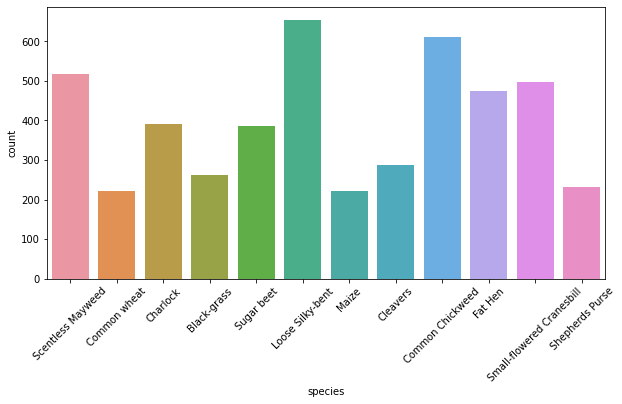

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt                        
%matplotlib inline 
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=train_Y,
    x='species'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

# **Display a random image from train image**

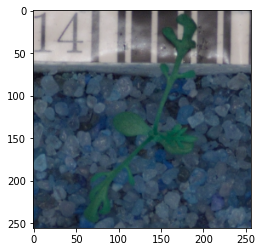

In [8]:
plt.imshow(train_X[20])

In [9]:
train_X.shape

(4750, 256, 256, 3)

In [10]:
train_Y['species'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: species, dtype: int64

# **Data Preprocessing**

*label Enoding the target*

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
le = LabelEncoder()
le.fit(train_Y['species'])
encoded_labels = le.transform(train_Y['species'])
train_label = np_utils.to_categorical(encoded_labels) #Data type: Number to Binary

In [12]:
train_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [13]:
#seed fixing
import random
import os
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

#  **TrainX Data slit using Stratify**

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_X, train_label,test_size=0.2,random_state=seed, stratify=train_label)

# Normalization****
**  Output_channel = 255 * (Input_channel - min) / (max-min)**

In [15]:
# Normalization of the Image Data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

# Check for a normalized random image

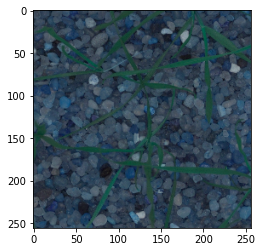

In [17]:
plt.imshow(X_train[10])

# Import ImageDataGenerator for Image Augmentation
**Prevents Overfit**

In [18]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

# Build Model: CNN Modelling

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(256, 256, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(12, activation='softmax'))

model.summary()

2023-01-17 05:31:44.510265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 05:31:44.513485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 05:31:44.828870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 05:31:44.829811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 05:31:44.830673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 252, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 128)     2

In [20]:
#Specify Lass and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Import & Apply Model Checkpoint & Early stopping

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
model_checkpoint = ModelCheckpoint('/kaggle/working/plantspecies_CNN_model.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
#Stop fitting if there's no enhancement of accuracy for 10 times.

# Fit Model

In [22]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=8), 
                    epochs=30, validation_data=(X_test, y_test),   
                    callbacks = [early_stopping, model_checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-01-17 05:33:48.791471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-17 05:33:52.362306: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


475/475 [==============================] - ETA: 0s - loss: 2.6313 - accuracy: 0.2574

2023-01-17 05:35:34.228321: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 747110400 exceeds 10% of free system memory.
2023-01-17 05:35:35.083247: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 747110400 exceeds 10% of free system memory.


475/475 [==============================] - 124s 223ms/step - loss: 2.6313 - accuracy: 0.2574 - val_loss: 2.0773 - val_accuracy: 0.3189

Epoch 00001: val_accuracy improved from -inf to 0.31895, saving model to /kaggle/working/plantspecies_CNN_model.h5
Epoch 2/30
475/475 [==============================] - 95s 199ms/step - loss: 2.0218 - accuracy: 0.3555 - val_loss: 1.8597 - val_accuracy: 0.3684

Epoch 00002: val_accuracy improved from 0.31895 to 0.36842, saving model to /kaggle/working/plantspecies_CNN_model.h5
Epoch 3/30
475/475 [==============================] - 94s 197ms/step - loss: 1.7015 - accuracy: 0.4403 - val_loss: 1.1854 - val_accuracy: 0.5705

Epoch 00003: val_accuracy improved from 0.36842 to 0.57053, saving model to /kaggle/working/plantspecies_CNN_model.h5
Epoch 4/30
475/475 [==============================] - 94s 198ms/step - loss: 1.4885 - accuracy: 0.5047 - val_loss: 1.5712 - val_accuracy: 0.4989

Epoch 00004: val_accuracy did not improve from 0.57053
Epoch 5/30
475/475 [

# Predict & Evaluate 

In [23]:
#Final score and accuracy of the model
score, acc = model.evaluate(X_test,y_test)
#score1, acc1 = model.evaluate(X_train,y_train)
print('Validation score:', score,'   Validation accuracy:', acc)
#print('Train score:', score1,'   Train accuracy:',acc1)

2023-01-17 06:22:28.749364: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 747110400 exceeds 10% of free system memory.
2023-01-17 06:22:29.888105: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 747110400 exceeds 10% of free system memory.


30/30 [==============================] - 4s 129ms/step - loss: 0.5289 - accuracy: 0.8221
Validation score: 0.5289052724838257    Validation accuracy: 0.8221052885055542


In [24]:
predictions = model.predict(X_test)

2023-01-17 06:22:58.288236: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 747110400 exceeds 10% of free system memory.


In [25]:
class_names = le.classes_

In [26]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = np.argmax(true_label[i])
  plt.grid(False)
  plt.xticks(range(12))
  plt.yticks([])
  thisplot = plt.bar(range(12), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [27]:
predictions[0]
#This value means confidence that corresponds to 12 species, and we can find the highest confidence by np.argmax

array([1.3673613e-06, 2.2058173e-03, 1.5291488e-03, 9.4089104e-05,
       7.8617020e-05, 1.4433100e-04, 2.2408113e-07, 9.9460781e-01,
       2.3146725e-04, 1.1150243e-05, 3.4389691e-04, 7.5215276e-04],
      dtype=float32)

**Check confodence**

In [28]:
np.argmax(predictions[0])

7

# Correct Prediction Check

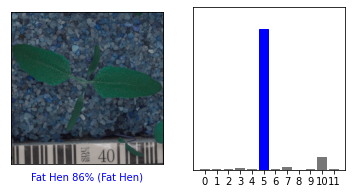

In [29]:
#Correct Prediction
i = 17
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

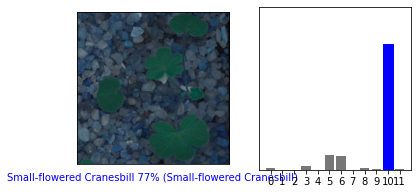

In [30]:
#Correct Prediction
i = 10
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

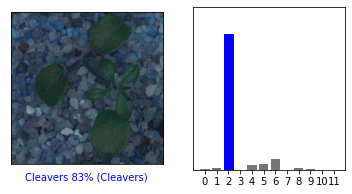

In [31]:
#Correct Prediction
i = 220
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

# Incorrect Prediction Check

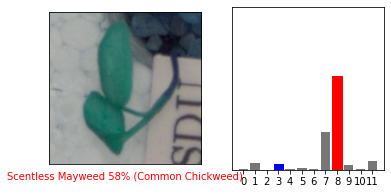

In [32]:
#Incorrect Prediction
i = 11
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

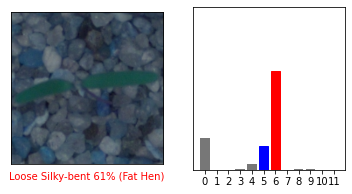

In [33]:
#Incorrect Prediction
i = 19
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

# Load & Normalise the Test Image

In [34]:
test_images_path = '/kaggle/input/plant-seedlings-classification/test/*.png'
test_images = glob(test_images_path)
test_images_arr = []
test_files = []

for img in test_images:
    test_images_arr.append(cv2.resize(cv2.imread(img), (256, 256)))
    test_files.append(img.split('/')[-1])

test_X = np.asarray(test_images_arr)

In [35]:
# Normalization of the Image Data
test_X = test_X.astype('float32') / 255

# Predict & Export to CSV

In [36]:
pred = model.predict(test_X)
pred_class = np.argmax(pred, axis=1)
pred_str = le.classes_[pred_class]
final_pred = {'file':test_files, 'species':pred_str}
final_pred = pd.DataFrame(final_pred)
final_pred.to_csv("Plant-Seedlings-CNN-kiy.csv", index=False)
#final_predictions